In [1]:
from fastai.data.all import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import accuracy, F1Score
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import AutoModelForSequenceClassification
import pandas as pd
from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import NLP as BLURR # lo importamos así para que sea compatible con el resto
from datasets import load_dataset, concatenate_datasets

/home/jonathan/.virtualenvs/huggingface/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
train_df = pd.read_csv('perplejidad/datasets/train_train_set.csv',delimiter='\t')

In [4]:
train_df['is_valid']=False

In [5]:
dl_kwargs = {"bs": 64, "val_bs": 64}
learn_kwargs = {"metrics": [accuracy]}

In [6]:
test_df = pd.read_csv('perplejidad/datasets/test_set.csv',delimiter='\t')

In [7]:
test_df['is_valid']=True

In [8]:
train_test_df = pd.concat([train_df,test_df])

In [9]:
train_idxs, test_idxs = L(range(len(train_test_df[train_test_df.is_valid==False]))), L(range(len(train_test_df[train_test_df.is_valid==False]), len(train_test_df)))

In [10]:
learnXLMRoberta = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "xlm-roberta-base",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [12]:
learnXLMRoberta.load('xlm-roberta-base')

In [13]:
learnBert = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "dccuchile/bert-base-spanish-wwm-uncased",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [14]:
learnBert.load('bert-new')

In [15]:
learnRoberta = BlearnerForSequenceClassification.from_data(
    train_test_df,
    "bertin-project/bertin-roberta-base-spanish",
    text_attr="Sentence",
    label_attr="Level",
    dblock_splitter=IndexSplitter(test_idxs),
    dl_kwargs=dl_kwargs,
    learner_kwargs=learn_kwargs,
)

In [16]:
learnRoberta.load('roberta-new')

In [17]:
predsRoberta,gt=learnRoberta.get_preds()
predsXLMRoberta,gt=learnXLMRoberta.get_preds()
predsBert,gt=learnBert.get_preds()

In [18]:
predsRoberta

tensor([[1.0435e-07, 6.1902e-08, 8.1447e-09, 1.0000e+00, 5.8850e-09],
        [2.6299e-10, 5.4022e-06, 9.9999e-01, 6.7078e-10, 2.5297e-07],
        [5.4502e-08, 5.0633e-02, 9.4933e-01, 1.4113e-07, 3.5272e-05],
        ...,
        [1.0000e+00, 6.9441e-09, 4.1595e-09, 5.1404e-11, 5.5410e-11],
        [3.9476e-10, 2.7861e-07, 1.0000e+00, 4.2548e-09, 2.7733e-09],
        [1.0000e+00, 9.4562e-10, 2.5724e-10, 3.7415e-10, 8.0209e-10]])

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score

In [24]:
accuracy_score(gt,np.argmax((predsRoberta+predsXLMRoberta+predsBert)/3,axis=1))

0.8113711659719995

In [27]:
cm = confusion_matrix(gt, np.argmax((predsRoberta+predsXLMRoberta+predsBert)/3,axis=1))

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=learnRoberta.dls.vocab)

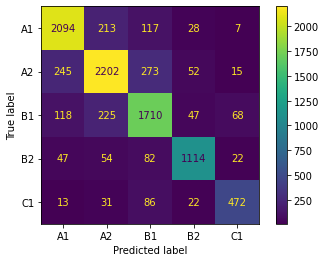

In [30]:
disp.plot()

In [33]:
preds = np.argmax((predsRoberta+predsXLMRoberta+predsBert)/3,axis=1)

In [41]:
for i,(x,y) in enumerate(zip(gt,preds)):
    if((x==4) and (y==0)):
        print(test_df.iloc[i].Sentence)

Dos hijas viven con él y la otra en Marseille .
Aquì ers solomente los huesos y los dientes .
 Feliz_Navidad
Mi madre , sin_embargo , que vive con nosotros , estuvo resfriada por una semana .
A ver adultos . .
Adi'os !
he visto ' avengers ' esta semana .
Resulatara muertos , dolores profundos .
Dice que hay un miembro de ellos en TOSHIBA .
con ocho oscares despues ....
Siendo yo aficionada a las películas , suelo ver las de cualquier género y época .
Vive en las afueras y no tiene dinero para sostentar su família y sus hermanos .
Es un hombre de negocios .


In [42]:
for i,(x,y) in enumerate(zip(gt,preds)):
    if((x==0) and (y==4)):
        print(test_df.iloc[i].Sentence)

No sabe aún si el niño es chico o chica .
Vivo en Rio_de_Janeiro en la calle_Engenho_da_Pedra,_1377_piso_105 .
Última película que vi , foi A_luz_de_tu_ojos , maravilhoso ...
Quien habla que los funcionarios no trabajan hablan sien razón .
 Hidden_Figures
¡ Espero su repuesta !
La psicologia antigua dice que la fuente de gran parte de las neurosis de una persona es la família , pero , principalmente la madre ... entonces , creó que su descrición será más interesante ...


In [38]:
test_df

,Unnamed: 0,Number,Word,Sentence,PpW2,PpW3,PpW4,PpW5,PpKenlm,Mother tongue,Level,is_valid
0,1000,518081,necesario,"Me gustaria tener informaciones sobre el precio de el programa y la duracion de cada nivel , por_favor es necesario saber si el alojamiento esta incluido .",5812.477796,15525.368873,27749.198276,36157.617688,2249.441791,Árabe,B2,True
1,75696,305398,y,Fuimos rapido a la parque y dentro_de la parque había cuatro mujeres que no podían salir porque la parque estaba cerrada .,10417.614305,26869.490397,39671.702823,43756.530750,2534.623254,Inglés,B1,True
2,303171,113448,de,La semana passada he biajado a marrakech para ver la cafeteria que ha sufrido de una explosión terorista en la plasa me encuentro una amiga antigua que no nos hamos visto desde 1983,18318.145081,43373.215379,66461.276833,77134.105946,3598.770393,Árabe,B1,True
3,10302,257239,que,Estoy esperando tu repuesta y espero que podrás ayudar la .,22787.581988,30042.864371,27105.101870,21405.012354,4078.286816,Árabe,B1,True
4,211078,48460,.,Admiro Lydia porque es muy fuerta .,23774.145632,21327.406113,15957.874962,11226.630721,9318.736115,Inglés,A2,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9352,151324,605157,tiempo,El tiempo era bastante bonito aunque en Francía estaba llovando mucho .,11000.848408,15785.623614,15545.249540,13192.598180,9827.414408,Francés,A2,True
9353,28097,280490,su,"Ahora está viviendo en Berlin con su novia , hace un master de la automatica .",2898.197170,7900.798061,13271.979210,16210.611272,6157.978035,Chino mandarín,A2,True
9354,90728,4665,",","Adiòs ,",40439.816095,12118.100296,5303.097765,2965.636513,19890.861921,Árabe,A1,True
9355,42031,105624,de,"En la 11_de_Noviembre , yo tome el vuelo de once_en_la_manana de Chicago a Nueva_York .",11449.915173,18537.417478,20904.434506,19282.894437,13335.536439,Inglés,B1,True
